In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import os
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import numpy as np
from datetime import datetime
import pandas as pd
import random 
from torchvision.datasets import ImageFolder
import re
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import roc_auc_score
from skimage.io import imread, imsave
import skimage
from PIL import ImageFile
from PIL import Image
from moco import SupConLoss, my_Densenet1
torch.cuda.empty_cache()

In [2]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

########## Mean and std are calculated from the train dataset
# normalize = transforms.Normalize(mean=[0.45271412, 0.45271412, 0.45271412],
#                                      std=[0.33165374, 0.33165374, 0.33165374])
# train_transformer = transforms.Compose([
#     transforms.Resize(256),
#     transforms.RandomResizedCrop((224),scale=(0.5,1.0)),
#     transforms.RandomHorizontalFlip(),
# #     transforms.RandomRotation(90),
#     # random brightness and random contrast
#     transforms.ColorJitter(brightness=0.2, contrast=0.2),
#     transforms.ToTensor(),
#     normalize
# ])
class TwoCropTransform:
    """Create two crops of the same image"""

    def __init__(self, transform, transform2=None):
        self.transform = transform
        self.transform2 = transform if transform2 is None else transform2

    def __call__(self, x):
        return [self.transform(x), self.transform2(x)]

train_transform1 = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ])
train_transform2 = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(size=224, scale=(0.2, 1.)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([
        transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
        ], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
        normalize,
    ])
train_transformer = TwoCropTransform(train_transform1, train_transform2)

val_transformer = transforms.Compose([
#     transforms.Resize(224),
#     transforms.CenterCrop(224),
    transforms.Resize((448,448)),
    transforms.ToTensor(),
    normalize
])

In [3]:
'''Load LUNA dataset'''

# import h5py 
# import numpy as np
# import skimage
# import torch
# from torch.utils.data import DataLoader
# from torch.utils.data import TensorDataset
# f = h5py.File('all_patches.hdf5','r')
# f.keys()
# img = f['ct_slices'][:]  
# label = f['slice_class'][:] 
# f.close()
# print(np.shape(img))
# print('b',np.shape(label))
# skimage.io.imshow(img[120])
# print(label[120])
# batchsize=4

# class LungDataset(Dataset):
#     def __init__(self, img, label, transform=None):
#         self.img = img
#         self.label = label
#         self.transform = transform

#     def __len__(self):
#         return len(self.img)

#     def __getitem__(self, idx):
#         if torch.is_tensor(idx):
#             idx = idx.tolist()
        
#         image = PIL_image = Image.fromarray(self.img[idx]).convert('RGB')

#         if self.transform:
#             image = self.transform(image)
#         sample = {'img': image,
#                   'label': int(self.label[idx])}
#         return sample
    
# trainset = LungDataset(img, label, transform= val_transformer)
# valset = LungDataset(img, label, transform= val_transformer)
# train_loader = DataLoader(trainset, batch_size=batchsize, drop_last=False, shuffle=True)
# val_loader = DataLoader(valset, batch_size=batchsize, drop_last=False, shuffle=False)
# modelname = 'medical_transfer'

'Load LUNA dataset'

In [4]:
batchsize=10
def read_txt(txt_path):
    with open(txt_path) as f:
        lines = f.readlines()
    txt_data = [line.strip() for line in lines]
    return txt_data

class CovidCTDataset(Dataset):
    def __init__(self, root_dir, txt_COVID, txt_NonCOVID, transform=None):
        """
        Args:
            txt_path (string): Path to the txt file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        File structure:
        - root_dir
            - CT_COVID
                - img1.png
                - img2.png
                - ......
            - CT_NonCOVID
                - img1.png
                - img2.png
                - ......
        """
        self.root_dir = root_dir
        self.txt_path = [txt_COVID,txt_NonCOVID]
        self.classes = ['CT_COVID', 'CT_NonCOVID']
        self.num_cls = len(self.classes)
        self.img_list = []
        for c in range(self.num_cls):
            cls_list = [[os.path.join(self.root_dir,self.classes[c],item), c] for item in read_txt(self.txt_path[c])]
            self.img_list += cls_list
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.img_list[idx][0]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        sample = {'img': image,
                  'label': int(self.img_list[idx][1])}
        return sample



    
if __name__ == '__main__':
    trainset = CovidCTDataset(root_dir='/home/wangchenxu/covid/Images-processed',
                                   txt_COVID='/home/wangchenxu/covid/Data-split/COVID/trainCT_COVID.txt',
                                   txt_NonCOVID='/home/wangchenxu/covid/Data-split/NonCOVID/trainCT_NonCOVID.txt',
                                   transform=train_transformer)
    valset = CovidCTDataset(root_dir='/home/wangchenxu/covid/Images-processed',
                                 txt_COVID='/home/wangchenxu/covid/Data-split/COVID/valCT_COVID.txt',
                                 txt_NonCOVID='/home/wangchenxu/covid/Data-split/NonCOVID/valCT_NonCOVID.txt',
                                 transform=val_transformer)
    testset = CovidCTDataset(root_dir='/home/wangchenxu/covid/Images-processed',
                                 txt_COVID='/home/wangchenxu/covid/Data-split/COVID/testCT_COVID.txt',
                                 txt_NonCOVID='/home/wangchenxu/covid/Data-split/NonCOVID/testCT_NonCOVID.txt',
                                 transform=val_transformer)
    print(trainset.__len__())
    print(valset.__len__())
    print(testset.__len__())

    train_loader = DataLoader(trainset, batch_size=batchsize, drop_last=False, shuffle=True)
    val_loader = DataLoader(valset, batch_size=batchsize, drop_last=False, shuffle=False)
    test_loader = DataLoader(testset, batch_size=batchsize, drop_last=False, shuffle=False)
    

425
118
203


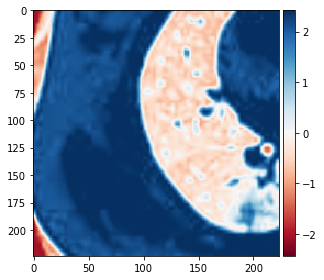

In [5]:
for batch_index, batch_samples in enumerate(train_loader): 
        batch_samples['img'] = torch.cat([batch_samples['img'][0], batch_samples['img'][1]], dim=0)
#         batch_samples['label'] = torch.cat([batch_samples['label'][0], batch_samples['label'][1]], dim=0)
#           print(type(batch_samples['label']))
#         print(batch_samples['label'])
        data, target = batch_samples['img'], batch_samples['label']
#         data = torch.cat([data[0],data[1]],dim=0)
#         print(target)
skimage.io.imshow(data[0,1,:,:].numpy())
# data[0].shape,data[1].shape

In [6]:
#training process is defined here 

alpha = None
## alpha is None if mixup is not used
alpha_name = f'{alpha}'

device = 'cuda'

def train(optimizer, epoch):
    
    model.train()
    
    train_loss = 0
    train_correct = 0
    
    for batch_index, batch_samples in enumerate(train_loader):
        
        # move data to device
        batch_samples['img'] = torch.cat([batch_samples['img'][0], batch_samples['img'][1]], dim=0)
#         data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)
        data, target = batch_samples['img'].cuda(), batch_samples['label'].cuda()
        
        ## adjust data to meet the input dimension of model
#         data = data[:, 0, :, :]
#         data = data[:, None, :, :]    
        
        #mixup
#         data, targets_a, targets_b, lam = mixup_data(data, target, alpha, use_cuda=True)
        
#         target = target.cuda(None, non_blocking=True)
        optimizer.zero_grad()
        bsz = target.shape[0]
        
        output,features = model(data)
#         out = model(data)
#         output = out
#         features = F.normalize(out, dim=1)
        criteria = nn.CrossEntropyLoss()
        criterion = SupConLoss.SupConLoss()
        loss1 = criteria(output, target.repeat(2).long())
        f1, f2 = torch.split(features, [bsz, bsz], dim=0)
        features = torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)
        loss2 = criterion(features, target.long())
        loss = loss1 + 0.01*loss2
        #mixup loss
#         loss = mixup_criterion(criteria, output, targets_a, targets_b, lam)

        train_loss += criteria(output, target.repeat(2).long())+criterion(features, target.long()) 
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        pred = output.argmax(dim=1, keepdim=True)
        train_correct += pred.eq(target.repeat(2).long().view_as(pred)).sum().item()
    
        # Display progress and write to tensorboard
        if batch_index % bs == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}'.format(
                epoch, batch_index, len(train_loader),
                100.0 * batch_index / len(train_loader), loss.item()/ bs))
    
#     print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#         train_loss/len(train_loader.dataset), train_correct, len(train_loader.dataset),
#         100.0 * train_correct / len(train_loader.dataset)))
#     f = open('model_result/{}.txt'.format(modelname), 'a+')
#     f.write('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#         train_loss/len(train_loader.dataset), train_correct, len(train_loader.dataset),
#         100.0 * train_correct / len(train_loader.dataset)))
#     f.write('\n')
#     f.close()

In [7]:
#val process is defined here

def val(epoch):
    
    model.eval()
    test_loss = 0
    correct = 0
    results = []
    
    TP = 0
    TN = 0
    FN = 0
    FP = 0
    
    
    criteria = nn.CrossEntropyLoss()
    # Don't update model
    with torch.no_grad():
        tpr_list = []
        fpr_list = []
        
        predlist=[]
        scorelist=[]
        targetlist=[]
        # Predict
        for batch_index, batch_samples in enumerate(val_loader):
            data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)
            
#             data = data[:, 0, :, :]
#             data = data[:, None, :, :]
            output, feature = model(data)
#             out = model(data)
#             output = out
#             feature = F.normalize(out, dim=1)
            test_loss += criteria(output, target.long())
            score = F.softmax(output, dim=1)
            pred = output.argmax(dim=1, keepdim=True)
#             print('target',target.long()[:, 2].view_as(pred))
            correct += pred.eq(target.long().view_as(pred)).sum().item()
            
#             print(output[:,1].cpu().numpy())
#             print((output[:,1]+output[:,0]).cpu().numpy())
#             predcpu=(output[:,1].cpu().numpy())/((output[:,1]+output[:,0]).cpu().numpy())
            targetcpu=target.long().cpu().numpy()
            predlist=np.append(predlist, pred.cpu().numpy())
            scorelist=np.append(scorelist, score.cpu().numpy()[:,1])
            targetlist=np.append(targetlist,targetcpu)
           
    return targetlist, scorelist, predlist
    
    # Write to tensorboard
#     writer.add_scalar('Test Accuracy', 100.0 * correct / len(test_loader.dataset), epoch)

In [8]:
#test process is defined here 

def test(epoch):
    
    model.eval()
    test_loss = 0
    correct = 0
    results = []
    
    TP = 0
    TN = 0
    FN = 0
    FP = 0
    
    
    criteria = nn.CrossEntropyLoss()
    # Don't update model
    with torch.no_grad():
        tpr_list = []
        fpr_list = []
        
        predlist=[]
        scorelist=[]
        targetlist=[]
        # Predict
        for batch_index, batch_samples in enumerate(test_loader):
            data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)
#             data = data[:, 0, :, :]
#             data = data[:, None, :, :]
#             print(target)
            output, feature = model(data)
#             out = model(data)
#             output = out
#             feature = F.normalize(out, dim=1)
            test_loss += criteria(output, target.long())
            score = F.softmax(output, dim=1)
            pred = output.argmax(dim=1, keepdim=True)
#             print('target',target.long()[:, 2].view_as(pred))
            correct += pred.eq(target.long().view_as(pred)).sum().item()
#             TP += ((pred == 1) & (target.long()[:, 2].view_as(pred).data == 1)).cpu().sum()
#             TN += ((pred == 0) & (target.long()[:, 2].view_as(pred) == 0)).cpu().sum()
# #             # FN    predict 0 label 1
#             FN += ((pred == 0) & (target.long()[:, 2].view_as(pred) == 1)).cpu().sum()
# #             # FP    predict 1 label 0
#             FP += ((pred == 1) & (target.long()[:, 2].view_as(pred) == 0)).cpu().sum()
#             print(TP,TN,FN,FP)
            
            
#             print(output[:,1].cpu().numpy())
#             print((output[:,1]+output[:,0]).cpu().numpy())
#             predcpu=(output[:,1].cpu().numpy())/((output[:,1]+output[:,0]).cpu().numpy())
            targetcpu=target.long().cpu().numpy()
            predlist=np.append(predlist, pred.cpu().numpy())
            scorelist=np.append(scorelist, score.cpu().numpy()[:,1])
            targetlist=np.append(targetlist,targetcpu)
    return targetlist, scorelist, predlist
    
    # Write to tensorboard
#     writer.add_scalar('Test Accuracy', 100.0 * correct / len(test_loader.dataset), epoch)

In [9]:
### Dense169
import torchvision.models as models
# model = models.densenet169(pretrained=True).cuda()
model = my_Densenet1.densenet169(pretrained=True).cuda()
# # modelname = 'Dense169'
"""load MoCo pretrained model"""
checkpoint = torch.load('save_model_dense1/checkpoint_luna_covid_KL++.tar')
# # # print(checkpoint['arch'])

state_dict = checkpoint['state_dict']
for key in list(state_dict.keys()):
    if 'module.encoder_q' in key:
#         print(key[17:])
        new_key = key[17:]
        state_dict[new_key] = state_dict[key]
    del state_dict[key]
for key in list(state_dict.keys()):
    if  key == 'classifier.0.weight':
        new_key = 'classifier.weight'
        state_dict[new_key] = state_dict[key]
        del state_dict[key]
    if  key == 'classifier.0.bias':
        new_key = 'classifier.bias'
        state_dict[new_key] = state_dict[key]
        del state_dict[key]
    if  key == 'classifier.2.weight' or key == 'classifier.2.bias':
        new_key = key.replace('classifier.2', 'classifier2')
        state_dict[new_key] = state_dict[key]
        del state_dict[key]
state_dict['classifier.weight'] = state_dict['classifier.weight'][:1000,:]
state_dict['classifier.bias'] = state_dict['classifier.bias'][:1000]
model.load_state_dict(checkpoint['state_dict'])

# # # print(model)

<All keys matched successfully>

In [10]:
"""Load Self-Trans model"""
"""Change names and locations to the Self-Trans.pt"""


# model = models.densenet169(pretrained=True).cuda()
# # pretrained_net = torch.load('model_backup/Dense169.pt')
# # pretrained_net = torch.load('model_backup/mixup/Dense169_0.6.pt')
# pretrained_net = torch.load('save_model_dense/Dense169_ssl_luna_moco_None_covid_moco_covid.pt')


# model.load_state_dict(pretrained_net)

# modelname = 'Dense169_ssl_luna_moco'

'Change names and locations to the Self-Trans.pt'

In [11]:
# train
bs =batchsize
votenum = 10
import warnings
warnings.filterwarnings('ignore')

r_list = []
p_list = []
acc_list = []
AUC_list = []
# TP = 0
# TN = 0
# FN = 0# FP = 0
vote_pred = np.zeros(valset.__len__())
vote_score = np.zeros(valset.__len__())

optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum = 0.9, weight_decay=1e-4)
# optimizer = optim.Adam(model.parameters(), lr=0.0001)
total_epoch = 200
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_epoch)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.95)
# scheduler = StepLR(optimizer, step_size=1)

for epoch in range(1, total_epoch+1):
    
    scheduler.step() 
    train(optimizer, epoch)
    
    targetlist, scorelist, predlist = val(epoch)
    print('target',targetlist)
    print('score',scorelist)
    print('predict',predlist)
    vote_pred = vote_pred + predlist 
    vote_score = vote_score + scorelist 

    if epoch % votenum == 0:
        
        # major vote
        vote_pred[vote_pred <= (votenum/2)] = 0
        vote_pred[vote_pred > (votenum/2)] = 1
        vote_score = vote_score/votenum
        
        print('vote_pred', vote_pred)
        print('targetlist', targetlist)
        TP = ((vote_pred == 1) & (targetlist == 1)).sum()
        TN = ((vote_pred == 0) & (targetlist == 0)).sum()
        FN = ((vote_pred == 0) & (targetlist == 1)).sum()
        FP = ((vote_pred == 1) & (targetlist == 0)).sum()
        
        
        print('TP=',TP,'TN=',TN,'FN=',FN,'FP=',FP)
        print('TP+FP',TP+FP)
        p = TP / (TP + FP)
        print('precision',p)
        p = TP / (TP + FP)
        r = TP / (TP + FN)
        print('recall',r)
        F1 = 2 * r * p / (r + p)
        acc = (TP + TN) / (TP + TN + FP + FN)
        print('F1',F1)
        print('acc',acc)
        AUC = roc_auc_score(targetlist, vote_score)
        print('AUCp', roc_auc_score(targetlist, vote_pred))
        print('AUC', AUC)
        
           
        
#         if epoch == total_epoch:
        torch.save(model.state_dict(), "save_model_dense1/moco_covid_myDensenet++.pt")  
        
        vote_pred = np.zeros(valset.__len__())
        vote_score = np.zeros(valset.__len__())
        print('\n The epoch is {}, average recall: {:.4f}, average precision: {:.4f},\
average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}'.format(
        epoch, r, p, F1, acc, AUC))

#         f = open('model_result/medical_transfer/{}_{}.txt'.format(modelname,alpha_name), 'a+')
#         f.write('\n The epoch is {}, average recall: {:.4f}, average precision: {:.4f},\
# average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}'.format(
#         epoch, r, p, F1, acc, AUC))
#         f.close()



Train Epoch: 1 [0/43 (0%)]	Train Loss: 2.391961
Train Epoch: 1 [10/43 (23%)]	Train Loss: 7.451926
Train Epoch: 1 [20/43 (47%)]	Train Loss: 4.202141
Train Epoch: 1 [30/43 (70%)]	Train Loss: 1.459735
Train Epoch: 1 [40/43 (93%)]	Train Loss: 3.176539
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [6.44624243e-10 2.29629737e-09 3.91892241e-10 8.92789842e-10
 1.09942444e-09 2.33138380e-08 6.85608228e-08 1.06315898e-08
 1.02737188e-08 1.77536791e-10 1.70199066e-09 8.33719405e-09
 8.57325091e-08 2.64528177e-09 1.60978502e-08 8.23905744e-09
 3.88022023e-08 9.95067584e-10 6.54154286e-09 2.04767403e-09
 3.46191009e-09 9.58525481e-10 2.07420129e-07 1.80353403e-08
 1.31487532e-

Train Epoch: 5 [0/43 (0%)]	Train Loss: 0.410069
Train Epoch: 5 [10/43 (23%)]	Train Loss: 0.642704
Train Epoch: 5 [20/43 (47%)]	Train Loss: 0.918706
Train Epoch: 5 [30/43 (70%)]	Train Loss: 0.226871
Train Epoch: 5 [40/43 (93%)]	Train Loss: 0.118632
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [6.69254689e-03 2.02305242e-01 4.45106191e-12 8.97458643e-02
 1.60299009e-03 2.78591353e-04 5.61552942e-01 4.15685251e-02
 7.75383727e-04 1.24596304e-03 3.21048309e-12 4.94098932e-01
 1.39551861e-02 1.16751026e-02 1.74702238e-02 2.37550028e-03
 1.85923517e-01 7.88556505e-03 1.09676711e-01 6.58557797e-03
 4.64681417e-01 1.99872300e-01 3.78662914e-01 1.57599263e-02
 2.36431062e-

Train Epoch: 8 [0/43 (0%)]	Train Loss: 1.224564
Train Epoch: 8 [10/43 (23%)]	Train Loss: 0.130889
Train Epoch: 8 [20/43 (47%)]	Train Loss: 0.258395
Train Epoch: 8 [30/43 (70%)]	Train Loss: 0.246281
Train Epoch: 8 [40/43 (93%)]	Train Loss: 0.372736
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.99976367 0.99992108 0.99969709 0.99853349 0.98079854 0.97913796
 0.99993944 0.99877948 0.99050647 0.90882862 0.85510552 0.83607417
 0.94148248 0.99930489 0.99917006 0.98893601 1.         0.88407135
 0.72386986 0.97863239 0.97658545 0.78761804 0.94227183 0.95685554
 0.76431078 0.84233391 0.93134212 0.97634238 0.87947351 0.9766376
 0.77779114 0.9680903  0.98170358 0.82392907 


 The epoch is 10, average recall: 0.0345, average precision: 0.2500,average F1: 0.0606, average accuracy: 0.4746, average AUC: 0.4072
Train Epoch: 11 [0/43 (0%)]	Train Loss: 0.086067
Train Epoch: 11 [10/43 (23%)]	Train Loss: 0.192770
Train Epoch: 11 [20/43 (47%)]	Train Loss: 0.087947
Train Epoch: 11 [30/43 (70%)]	Train Loss: 0.096351
Train Epoch: 11 [40/43 (93%)]	Train Loss: 0.182746
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.99972612 0.99999988 0.99999833 1.         0.99991786 0.98433787
 0.99999952 0.99710339 0.87572759 0.99302685 0.99809676 0.9998349
 0.99970692 1.         1.         0.9717319  1.         0.99611473
 0.99391729 0.95341593 0.99295968 0.997

KeyboardInterrupt: 

In [ ]:
# test
bs = 10
import warnings
warnings.filterwarnings('ignore')

epoch = 1
r_list = []
p_list = []
acc_list = []
AUC_list = []
# TP = 0
# TN = 0
# FN = 0
# FP = 0
vote_pred = np.zeros(testset.__len__())
vote_score = np.zeros(testset.__len__())


targetlist, scorelist, predlist = test(epoch)
print('target',targetlist)
print('score',scorelist)
print('predict',predlist)
vote_pred = vote_pred + predlist 
vote_score = vote_score + scorelist 

TP = ((predlist == 1) & (targetlist == 1)).sum()

TN = ((predlist == 0) & (targetlist == 0)).sum()
FN = ((predlist == 0) & (targetlist == 1)).sum()
FP = ((predlist == 1) & (targetlist == 0)).sum()

print('TP=',TP,'TN=',TN,'FN=',FN,'FP=',FP)
print('TP+FP',TP+FP)
p = TP / (TP + FP)
print('precision',p)
p = TP / (TP + FP)
r = TP / (TP + FN)
print('recall',r)
F1 = 2 * r * p / (r + p)
acc = (TP + TN) / (TP + TN + FP + FN)
print('F1',F1)
print('acc',acc)
AUC = roc_auc_score(targetlist, vote_score)
print('AUC', AUC)

# f = open(f'model_result/medical_transfer/test_{modelname}_{alpha_name}_LUNA_moco_CT_moco.txt', 'a+')
# f.write('\n The epoch is {}, average recall: {:.4f}, average precision: {:.4f},\
# average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}'.format(
# epoch, r, p, F1, acc, AUC))
# f.close()
# torch.save(model.state_dict(), "model_backup/medical_transfer/{}_{}_covid_moco_covid.pt".format(modelname,alpha_name))
